# Population annealing on spin glass problem

In this jupyter notebook you can fins the implementation of the algorithm population annealing to find the ground state of an 2D Edwards-Anderson spin glass model, which has the following Hamiltonian:

$$H = -\sum_{<ij>}J_{ij}s_is_j,$$

where the couplings $J_{ij}$ are random variables drawn from a Gaussian distribution and we consider only nearest neighbour interactions.
The algorithm can also be implemented for other spin glass problems with different connectivity and dimensionality.

Population annealing is inspired in the simulated annealing algorithm but it has some added features.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import timeit
import math

After importing the necessary packages we need to define the configuration of the problem. Let's start by defining the lattice. This will be useful to plot the spins.

In [2]:
def Lattice(N):
    '''Square 2D lattice within sqrtN'''
    Position = np.zeros((N,2))
    SqrtN = np.ceil(np.sqrt(N)) 
    for i in range(N):
        Position[i][0] = (i%SqrtN)
        Position[i][1] = (i//SqrtN)  
    SpinX = Position[:,0]
    SpinY = Position[:,1]
    return SpinX, SpinY

side = 10
N = side*side #TOTAL NUMBER OF SPINS
SpinX,SpinY = Lattice(N)

Now, let us define the random couplings between nearest neighbours. In this case, we will set them in a NxN matrix, but there are more efficient ways to do it. For example, we could save two couplings for each spin, the one to the left and the one with the spin down from it. Here instead we have a symmetric matrix with a lot of entries being zero, but it helps making the program more intuitive.

In [3]:
def NN_Random_couplings(N, side, SpinX, SpinY):
    '''Computes the symmetric matrix with all random couplings for nearest neighbours PERIODIC BOUNDARY CONDITIONS'''
    Matrix = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            dist_vector = np.array([SpinX[i]-SpinX[j],SpinY[i]-SpinY[j]])
            dist_vector_PBC = (dist_vector + side/2)%side-side/2
            if np.linalg.norm(dist_vector_PBC) == 1:
                Matrix[i][j] = np.random.normal(0,1) #from N(0,1)
                Matrix[j][i] = Matrix[i][j]
    return Matrix  

Matrix = NN_Random_couplings(N,side,SpinX,SpinY)
print(Matrix)
#np.save('Matrix.npy', Matrix)

[[ 0.          0.48407959  0.         ...  0.          0.
   0.        ]
 [ 0.48407959  0.         -0.03438626 ...  0.          0.
   0.        ]
 [ 0.         -0.03438626  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -0.0190945
   0.        ]
 [ 0.          0.          0.         ... -0.0190945   0.
   1.40401379]
 [ 0.          0.          0.         ...  0.          1.40401379
   0.        ]]


We could also import the couplings from a file to be sure we are working on the same problem all the time:

In [5]:
Matrix = np.load('Matrix10.npy')
print(Matrix)

[[ 0.          0.3764402   0.         ...  0.          0.
   0.        ]
 [ 0.3764402   0.         -1.89813204 ...  0.          0.
   0.        ]
 [ 0.         -1.89813204  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -1.79272444
   0.        ]
 [ 0.          0.          0.         ... -1.79272444  0.
  -0.70226097]
 [ 0.          0.          0.         ...  0.         -0.70226097
   0.        ]]


Now let us define the parameters that we are going to need for the population annealing process. The idea behind this algorithm is to consider more than one copy of the system and perform simulated annealing to all of them. At each temperature step, we will resample the copies so that they follow the Gibbs distribution, therefore getting rid of some of the high energy copies.
- Instead of the Temperature, here we will work with the Beta, which is just 1/T.
- The cooling schedule in this case will be linear.

In [14]:
StartBeta = 0
EndBeta = 5
CoolingFactor = 5/50 #Here we will use a linear cooling schedule, so tempera
Ne = 10
Replicas = 150 

Now let's define the core function of the problem, which will perform a Metropolis sweep over the lattice (this means flipping N spins). The sweep is performed in sequential order, but we could consider N random spins and it should also work. 

First, we will need to define a function that computes the new energy by JUST considering the difference that we obtain from flipping one spin. Since we consider nearest neighbours, computing the whole energy again would be not efficient. Instead, we only have to change the sign of the four interactions that correspond to this one spin. This function can induce some error when we are doing a high number of iterations, and that is why we will do the whole calculation of the energy once in a while.

In [15]:
def Swap(State, Energy, Matrix, i):
    '''Computes the new energy obtained by flipping spin i'''
    NewEnergy = copy.deepcopy(Energy)
    State = np.array(State, float)
    for j in range(N):
        NewEnergy += float(4)*Matrix[i][j]*State[i]*State[j]
    return NewEnergy

The metropolis algorithm is based in the following idea. At a given temperature T, we will ALWAYS accept the moves that lower the energy. The ones that increase it will be accepted depending on a probability that is based on the Boltzmann distribution. Here we have to use random numbers to decide whether we are accepting the perturbation or not.

In [16]:
def Metropolis_sweep(State, Energy, BestEnergy, BestState, Matrix, Beta, N):
    '''Performs a N steps in the Metropolis algorithm and decides whether 
    to accept the moves or not in a given T'''    
    for i in range(N):
        spin = i
        NewEnergy = Swap(State, Energy, Matrix, spin)
        Dif = NewEnergy - Energy
        if Dif < 0: 
            State[spin] = -State[spin]
            Energy = NewEnergy
            if Energy < BestEnergy:
                BestState = copy.deepcopy(State)
                BestEnergy = Energy 
        else:
            Prob = np.exp(-Dif*Beta)
            dummy = random.random()
            if dummy < Prob:
                State[spin] = -State[spin]
                Energy = NewEnergy  
    return State, Energy, BestEnergy, BestState

We will also need a function that, given a vector of configuration of spins, finds the energy of each configuration (with the Hamiltonian that was previously given for EA spin glass).  Here we could add a factor 1/2N.

In [17]:
def Hamiltonian_all(States, Matrix, N):
    '''Computes the cost energy of a a given SET of states'''
    Energies = []
    for confg in States:
        Energy = 0
        confg = np.array(confg, float)
        for i in range(N):
            for j in range(N):
                Energy += -Matrix[i][j]*confg[i]*confg[j]
        Energies = np.append(Energies, Energy)
    return Energies

And we will keep the function that finds the energy of one state because it can be useful later.

In [18]:
def Hamiltonian_one(Spins, Matrix, N):
    '''Computes the cost energy of a given state'''
    Energy = 0
    Spins = np.array(Spins, float)
    for i in range(N):
        for j in range(N):
            Energy += -Matrix[i][j]*Spins[i]*Spins[j]
    return Energy

Now let us define the starting random configuration, which in this case is a configuration for each of the replicas. We will need to apply Simulated Annealing to each of them.

In [19]:
States = []
for replica in range(Replicas):
    if len(States) == 0:
        States = np.sign(np.random.rand(N)*2-1)
    else:
        States = np.vstack((States, np.sign(np.random.rand(N)*2-1)))

We can plot the initial state of one of the replicas to see how it looks like.

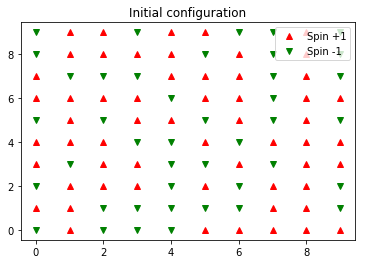

In [20]:
def PlotState(title, State, SpinX, SpinY):
    '''Plots the spin state'''
    plt.figure()
    plt.title(title)
    plt.plot(SpinX[State>0],SpinY[State>0],color='red',marker='^',linestyle='None',label='Spin +1')
    plt.plot(SpinX[State<0],SpinY[State<0],color='green',marker='v',linestyle='None',label='Spin -1')
    plt.legend()

PlotState('Initial configuration', States[0], SpinX, SpinY)  

Now we will start with the process of minimizing the energy. Note that we will save the best energy (and the best state corresponding to it) througout the process and that will be our result.
This process would be much faster if we were be parellelizing it. We won't do this in this code, but it would be an interesting implementation.

The procedure will be, for each temperature: Apply SA to all of the replicas and compute $\tau$, which will tell us how to resample the set. From $\tau$, we need to extract an integer number, which will be the number of copies for each configuration. This can be done in many ways, but here we will consider the nearest-integer probability to resample.

In [21]:
Beta = StartBeta
Energies = Hamiltonian_all(States,Matrix,N)
BestEnergy = min(Energies)
BestState = States[Energies == BestEnergy]    
BestState = BestState[0]
EnergySteps = []

print('\nSTART POPULATION ANNEALING')
start_cycle = timeit.default_timer()
#Temperature steps
while Beta <= EndBeta:
        
    print('\nBeta ', Beta)
        
    #PERFORM SA
    for ReplicaNum in range(len(Energies)):
        print('Replica {}'.format(ReplicaNum), end='\r')
        State = copy.deepcopy(States[ReplicaNum])
        Energy = Energies[ReplicaNum]
        for i in range(Ne):
            State,Energy,BestEnergy,BestState = Metropolis_sweep(State,Energy,BestEnergy,BestState,Matrix,Beta,N)
        States[ReplicaNum] = copy.deepcopy(BestState)
        Energies[ReplicaNum] = Hamiltonian_one(BestState,Matrix,N)
        
    print('MINIMUM ENERGY OF CURRENT CONFIGURATIONS: ', min(Energies))
    EnergySteps = np.append(EnergySteps, min(Energies))
    
    #COMPUTE FACTOR Q NEEDED FOR RESAMPLING
    NewBeta = Beta + CoolingFactor
    Q = 0
    for Energy in Energies:
        Q += math.exp(-(NewBeta-Beta)*Energy)/Replicas
    #RESAMPLE
    NewStates = []   
    NewEnergies = []
    for ReplicaNum in range(len(Energies)):
        tau = math.exp(-(NewBeta-Beta)*Energies[ReplicaNum])/Q
        dummy = random.random()
        if dummy >= (tau-round(tau)): #nearest-integer resampling
            n = math.ceil(tau)
        else:
            n = round(tau)
        #Create new vector of states and energies (that follows the Gibbs distribution)
        for i in range(n):
            if len(NewStates) == 0:
                NewStates = States[ReplicaNum]
            else:
                NewStates = np.vstack((NewStates, States[ReplicaNum]))
    States = copy.deepcopy(NewStates)
    Energies = Hamiltonian_all(States,Matrix,N)
    print('RESAMPLING: New number of copies: ', len(Energies))
    Beta = NewBeta
        
end_cycle = timeit.default_timer()
print('\nMINIMUM REACHED: ', BestEnergy)
print('TIME: ', end_cycle-start_cycle)         
    



START POPULATION ANNEALING

Beta  0
MINIMUM ENERGY OF CURRENT CONFIGURATIONS:  -103.72389112644032

RESAMPLING: New number of copies:  210

Beta  0.1
MINIMUM ENERGY OF CURRENT CONFIGURATIONS:  -176.99123581640825

RESAMPLING: New number of copies:  210

Beta  0.2
MINIMUM ENERGY OF CURRENT CONFIGURATIONS:  -217.03266164326268

RESAMPLING: New number of copies:  207

Beta  0.30000000000000004
MINIMUM ENERGY OF CURRENT CONFIGURATIONS:  -250.91615543112334

RESAMPLING: New number of copies:  197

Beta  0.4
MINIMUM ENERGY OF CURRENT CONFIGURATIONS:  -256.27622448962165

RESAMPLING: New number of copies:  196

Beta  0.5
MINIMUM ENERGY OF CURRENT CONFIGURATIONS:  -258.0486200328255

RESAMPLING: New number of copies:  196

Beta  0.6
MINIMUM ENERGY OF CURRENT CONFIGURATIONS:  -258.0486200328255

RESAMPLING: New number of copies:  196

Beta  0.7
MINIMUM ENERGY OF CURRENT CONFIGURATIONS:  -258.6720784194716

RESAMPLING: New number of copies:  196

Beta  0.7999999999999999
MINIMUM ENERGY OF CURRE

Now we can have a look at the state that was found with minimum energy.


THE MINIMUM ENERGY FOUND IS:  -258.67207841947175


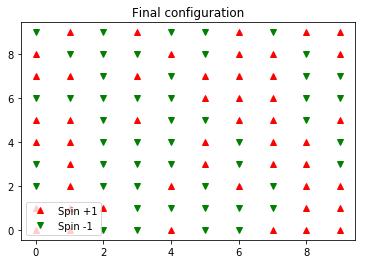

In [25]:
PlotState('Final configuration', BestState, SpinX, SpinY)
GroundState = BestEnergy
print('\nTHE MINIMUM ENERGY FOUND IS: ', GroundState)

And we can also look at the histogram of final states, to see how are they sampled. It could be that all of them are in the minimum state that was found.

Text(0.5,0,'Energy')

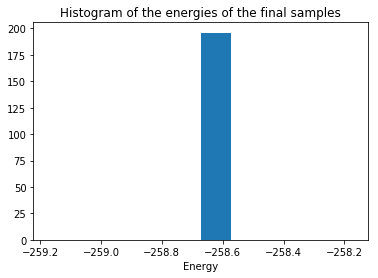

In [26]:
plt.figure()
plt.hist(Energies)
plt.title('Histogram of the energies of the final samples')
plt.xlabel('Energy')

The parameters for this algorithm still need to be tunned in order to get the most out of it. Moreover, if we would parallelize it we could work with a lot more replicas and therefore get a better result.
For now it is working, but we still do not get better results than using simulated annealing, which according to the literature should happen.